<a href="https://colab.research.google.com/github/zakizul2000/Webscraping/blob/main/SUSS_applied_project_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rake-nltk -q

In [ ]:
#import all packages and libraries
import nltk
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, roc_auc_score
from rake_nltk import Rake

#download NLTK
nltk.download('all')

In [ ]:
#import algorithm classes
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
#connect to Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#read Lush Reviews excel data and save into dataframes
new = pd.read_excel('/content/drive/My Drive/Colab Notebooks/new2-reviews.xlsx') #973 rows
coco_rice = pd.read_excel('/content/drive/My Drive/Colab Notebooks/cocoricecake-reviews.xlsx') #126 rows
soak_float = pd.read_excel('/content/drive/My Drive/Colab Notebooks/soakfloat-reviews.xlsx') #370 rows
jason_argan = pd.read_excel('/content/drive/My Drive/Colab Notebooks/jason-reviews.xlsx') #735 rows

#remove positive reviews from coco-rice, soak_float, jason_argon dataframes
coco_rice = coco_rice[(coco_rice['rating'] < 4)]
soak_float = soak_float[(soak_float['rating'] < 4)]
jason_argan = jason_argan[(jason_argan['rating'] < 4)]

#combine all dataframes
frames = [new, coco_rice, soak_float, jason_argan]
pre_df = pd.concat(frames, ignore_index=True, sort=False)

#print number of rows for each rating
#to determine how many rows to remove
#to create a balanced dataframe of positive and negative reviews
pre_df['rating'].value_counts()

5    627
4    226
3    147
2    145
1     95
Name: rating, dtype: int64

In [ ]:
#remove rows of positive reviews to acheive balanced dataframe
#5-rating: remove 434 rows
#4-rating: remove 32 rows
n_5 = 434
pre_df = pre_df.drop(pre_df[pre_df['rating'].eq(5)].sample(n_5).index)
n_4 = 32
df = pre_df.drop(pre_df[pre_df['rating'].eq(4)].sample(n_4).index)

#print number of rows for each rating
df['rating'].value_counts()

4    194
5    193
3    147
2    145
1     95
Name: rating, dtype: int64

In [ ]:
#rake-nltk analysis to find keywords
#collect positive reviews
positive = df[(df['rating'] > 4)]
positive = positive.drop(columns=['rating','title'])
positive = positive.reset_index()
positive = positive.drop(columns=['index'])
#collect negative reviews
negative = df[(df['rating'] < 3)]
negative = negative.drop(columns=['rating','title'])
negative = negative.reset_index()
negative = negative.drop(columns=['index'])

#concatenate into a single text body
#positive = positive['body'].str.cat(sep='')
#negative = negative['body'].str.cat(sep=', ')

In [ ]:
print(positive)

                                                  body
0    I have been using this shampoo bar since the b...
1    been using this for years and my hair grows at...
2    I'm young but have thinning hair from birth co...
3    I love this product but I use it as a body soa...
4    After a week of using New shampoo bar, I got m...
..                                                 ...
188  It lathers really quickly so you don't have to...
189  I LOVE THIS SHAMPOO. let me say that one more ...
190  I love this solid shampoo, it cleans in a snap...
191  This is my first shampoo bar and I loved it.\n...
192  I got this shampoo yesterday and I love it soo...

[193 rows x 1 columns]


In [ ]:
for i in positive['body']:
  r = Rake()
  r.extract_keywords_from_text(i)
  print(r.get_ranked_phrases_with_scores())
  print('\n')

In [ ]:
for i in negative['body']:
  r = Rake()
  r.extract_keywords_from_text(i)
  print(r.get_ranked_phrases_with_scores())
  print('\n')

In [ ]:
#data preprocessing
#apply NLP text cleaning methods

#remove stopwords
stop = stopwords.words('english')
df['without_stopwords'] = df['body'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#word tokenize and remove all non-alphabetic characters
tokenizer = RegexpTokenizer('\w+')
df['tokenized_sents'] = df.apply(lambda row: tokenizer.tokenize(row['without_stopwords']), axis=1)

#detokonize for TF-IDF feature extraction
df['detokenized'] = df.apply(lambda row: TreebankWordDetokenizer().detokenize(row['tokenized_sents']), axis=1)

#stem words
stemmer = SnowballStemmer('english')
df['review'] = df.apply(lambda row: stemmer.stem(row['detokenized']), axis=1)

#create column for sentiment 1-positive 0-negative
conditions = [
    (df['rating'] < 3),
    (df['rating'] > 3)
]
sentiment = [0, 1]
df['sentiment'] = np.select(conditions, sentiment, default=0)

#delete unnecessary columns
df1 = df.drop(columns=['title','rating','body','without_stopwords','tokenized_sents','detokenized'])
print(df1)

#print number of rows of each sentiment value
#dataframe is balanced
df['sentiment'].value_counts()

                                                 review  sentiment
1     i using new shampoo bar year i oily hair tried...          0
2     i using product years i would want use anythin...          1
6     i serious hair loss problem since i used produ...          1
8     i know expect i ve never tried shampoo bar i d...          1
10    if hesitant trying shampoo bars love good lath...          1
...                                                 ...        ...
1235  this second shampoo bar i gotten lush i never ...          0
1236  i wanted love bad it pretty gentle hair smelle...          0
1237  this shampoo really helps hair thicken pretty ...          0
1238  this first shampoo bar i impressed it crumbled...          0
1239  i love rose scents developed lush always fresh...          0

[774 rows x 2 columns]


0    387
1    387
Name: sentiment, dtype: int64

In [ ]:
#reset index
df1 = df1.reset_index()
print(df1.index)

RangeIndex(start=0, stop=774, step=1)


In [ ]:
#step 1 in finding optimal n_neighbors value
#split dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'].values , test_size=0.20, random_state=0)
# Show the size of our datasets
print('X Train Size:',X_train.shape)
print('X Test Size:',X_test.shape)

X Train Size: (619,)
X Test Size: (155,)


In [ ]:
#step 2 in finding optimal n_neighbors value
#feature extraction using TF-IDF
tfidf = TfidfVectorizer(decode_error='ignore', lowercase = True, min_df=2)
# Numericalize the train dataset
X_train = tfidf.fit_transform(X_train.values.astype('U'))
# Numericalize the test dataset
X_test = tfidf.transform(X_test.values.astype('U'))

In [ ]:
print(X_train.shape)
print(X_test.shape)

(619, 1884)
(155, 1884)


Maximum accuracy:- 0.7935483870967742 at K = 19


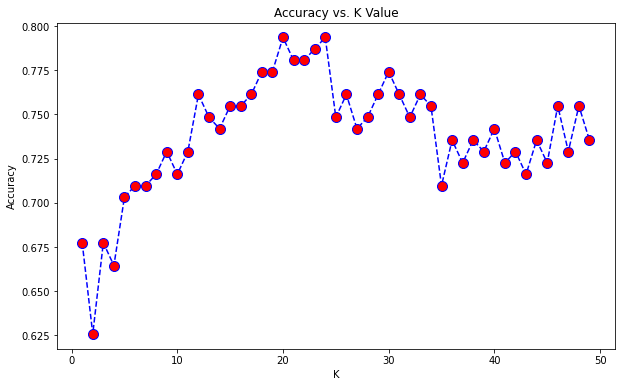

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics
#find optimal value of n_neighbors
error_rate = []
acc = []
for i in range(1,50):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(X_train, y_train)
  pred_i = knn.predict(X_test)
  error_rate.append(np.mean(pred_i != y_test))
  acc.append(metrics.accuracy_score(y_test, pred_i))

plt.figure(figsize=(10,6))
#plt.plot(range(1,50),error_rate,color='blue', linestyle='dashed', 
 #        marker='o',markerfacecolor='red', markersize=10)
plt.plot(range(1,50),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
#print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

In [ ]:
#k-fold cross validation
#from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
#skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=529)
skf = KFold(n_splits=10, shuffle=True, random_state=529)

In [ ]:
fold = 0
aucs = []
accs = []
for train_index, val_index in skf.split(df['review'], df['sentiment'], groups = None):
  #training set
  X_tr = df1['review'].loc[train_index]
  y_tr = df1['sentiment'].loc[train_index]
  #validation set
  X_val = df1['review'].loc[val_index]
  y_val = df1['sentiment'].loc[val_index]
  
  #perform TF-IDF
  tfidf = TfidfVectorizer(decode_error='ignore', lowercase = True, min_df=2)
  X_train = tfidf.fit_transform(X_tr.values.astype('U'))
  X_validation = tfidf.transform(X_val.values.astype('U'))

  #fit model on training set
  #best model: LR with hyperparameter tuning 'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'
  model = LogisticRegression()
  model.fit(X_train, y_tr)
  pred = model.predict(X_validation)
  pred_prob = model.predict_proba(X_validation)[:, 1]
  #get scores
  acc_score = accuracy_score(y_val, pred)
  auc_score = roc_auc_score(y_val, pred_prob)
  #print scores
  print(f"===== Fold {fold} =====")
  print(
      f"Accuracy on validation set: {acc_score:0.4f} and AUC: {auc_score:0.4f}"
  )
  fold += 1
  aucs.append(auc_score)
  accs.append(acc_score)

===== Fold 0 =====
Accuracy on validation set: 0.8462 and AUC: 0.8882
===== Fold 1 =====
Accuracy on validation set: 0.7949 and AUC: 0.8997
===== Fold 2 =====
Accuracy on validation set: 0.8077 and AUC: 0.9192
===== Fold 3 =====
Accuracy on validation set: 0.9103 and AUC: 0.9309
===== Fold 4 =====
Accuracy on validation set: 0.8052 and AUC: 0.9068
===== Fold 5 =====
Accuracy on validation set: 0.8312 and AUC: 0.9291
===== Fold 6 =====
Accuracy on validation set: 0.7792 and AUC: 0.9109
===== Fold 7 =====
Accuracy on validation set: 0.8571 and AUC: 0.9460
===== Fold 8 =====
Accuracy on validation set: 0.8312 and AUC: 0.9048
===== Fold 9 =====
Accuracy on validation set: 0.8052 and AUC: 0.8831


In [ ]:
oof_auc = np.mean(aucs)
print(f"Out of fold AUC score: {oof_auc:0.4f}")

oof_acc = np.mean(accs)
print(f"Out of fold ACC score: {oof_acc:0.4f}")

Out of fold AUC score: 0.9119
Out of fold ACC score: 0.8268


In [ ]:
#perform hyperparameter tuning to improve model accuracy
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
#define dataset 
tfidf = TfidfVectorizer(decode_error='ignore', lowercase = True, min_df=2)
X = tfidf.fit_transform(df['review'])
y = df['sentiment'] #target
#define models and parameters
LR_model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
#define grid search
grid = dict(solver=solvers, penalty=penalty, C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=LR_model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X,y)
#summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.836425 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.827744 (0.031155) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.827744 (0.031155) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.827744 (0.031155) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.832501 (0.039008) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.832501 (0.039008) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.832928 (0.037511) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.835997 (0.045519) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.835997 (0.045519) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.836425 (0.045792) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.825630 (0.045302) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.825630 (0.045302) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.824797 (0.047351) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.815673 (0.038874) wit